In [1]:
import json
import pandas as pd
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import random
import pickle
import os
import numpy as np
import gc

In [2]:
f = open('lotto_america_winning_nums.json', 'r')
data = json.load(f)

In [3]:
df = pd.DataFrame(data).transpose()
df.head()

,main_numbers,star_number,multiplier
"Wed, Dec 11, 2024","[4, 14, 30, 45, 50]",4,2x
"Mon, Dec 9, 2024","[15, 24, 29, 38, 51]",3,3x
"Sat, Dec 7, 2024","[7, 14, 31, 44, 46]",8,5x
"Wed, Dec 4, 2024","[10, 13, 32, 42, 44]",9,4x
"Mon, Dec 2, 2024","[1, 20, 37, 39, 47]",4,2x


In [4]:
df2 = pd.DataFrame(df)
ball_list = ['Ball 1', 'Ball 2', 'Ball 3', 'Ball 4', 'Ball 5']
df2[ball_list] \
    = pd.DataFrame(df.main_numbers.tolist(), index = df2.index)
df2 = df2.drop('main_numbers', axis=1)
cols = []
cols.extend(ball_list)
cols.append('star_number')
cols.append('multiplier')
df2 = df2[cols]
df2.rename(columns={'star_number': 'All Star Ball', 'multiplier' : 'Multiplier'}, inplace=True)
df2.head()

,Ball 1,Ball 2,Ball 3,Ball 4,Ball 5,All Star Ball,Multiplier
"Wed, Dec 11, 2024",4,14,30,45,50,4,2x
"Mon, Dec 9, 2024",15,24,29,38,51,3,3x
"Sat, Dec 7, 2024",7,14,31,44,46,8,5x
"Wed, Dec 4, 2024",10,13,32,42,44,9,4x
"Mon, Dec 2, 2024",1,20,37,39,47,4,2x


In [5]:
#Build a Law of Large Numbers Dataset to compare to
file_path = "synthetic_drawings.pickle"
lln_synthetic_draws = {}
#Anticipate needing ~ 32G of ram to run your usual stuff plus this
def generate_synthetic_draws(sample_draws=15000000):
    rng = np.random.default_rng()
    all_balls = range(1, 52 + 1)
    all_balls = np.array(all_balls, dtype=np.uint8) #Never enough RAM, I'm tempted to build some kind of dataloader
    allstar_balls = range(1, 10 + 1)
    allstar_balls = np.array(allstar_balls, dtype=np.uint8)
    lln_synthetic_draws = {}

    
    for i in np.array(range(sample_draws), dtype=np.uint32):
        drawing = np.sort(rng.choice(all_balls, size=5, replace=False))
        all_star = rng.choice(allstar_balls, size=1, replace=False)
        lln_synthetic_draws[i] = {"Balls" : drawing, "Allstar" : all_star}
    with open(file_path, 'wb') as f:
        pickle.dump(lln_synthetic_draws, f)
        f.flush()  # Ensure all data is written to disk 'fore we take out the trash
    lln_synthetic_draws.clear()
    gc.collect() #Seriously, never enough RAM
    print('Took out the garbage, sire')
    


if os.path.exists(file_path):
    with open(file_path, 'rb') as f:
        lln_synthetic_df = pd.DataFrame.from_dict(pickle.load(f), orient='index')
else:
    generate_synthetic_draws()
    with open(file_path, 'rb') as f:
        lln_synthetic_df = pd.DataFrame.from_dict(pickle.load(f), orient='index')
lln_synthetic_df.head()

,Balls,Allstar
0,"[17, 23, 30, 43, 46]",[9]
1,"[4, 19, 21, 32, 49]",[3]
2,"[2, 22, 23, 25, 41]",[1]
3,"[14, 22, 36, 43, 51]",[3]
4,"[2, 19, 29, 35, 46]",[8]


In [14]:
# Calculate ball frequency from synthetic draws
synthetic_counts = pd.Series([ball for sublist in lln_synthetic_df['Balls'] for ball in sublist]).value_counts(normalize=True)
synthetic_counts = synthetic_counts.reset_index()
synthetic_counts.columns = ['Ball Number', 'Synthetic Frequency']
synthetic_counts['Synthetic Frequency'] = synthetic_counts['Synthetic Frequency'] * 100

# Calculate ball frequency from real draws
real_counts = pd.Series(counts).value_counts(normalize=True).reset_index()
real_counts.columns = ['Ball Number', 'Real Frequency']
real_counts['Real Frequency'] = real_counts['Real Frequency'] * 100

# Merge synthetic and real frequencies into one DataFrame
combined_counts = pd.merge(real_counts, synthetic_counts, on='Ball Number', how='outer').fillna(0)

# Melt the data for easier plotting
combined_counts = pd.melt(combined_counts, id_vars=['Ball Number'], 
                        value_vars=['Real Frequency', 'Synthetic Frequency'], 
                        var_name='Category', value_name='Frequency')

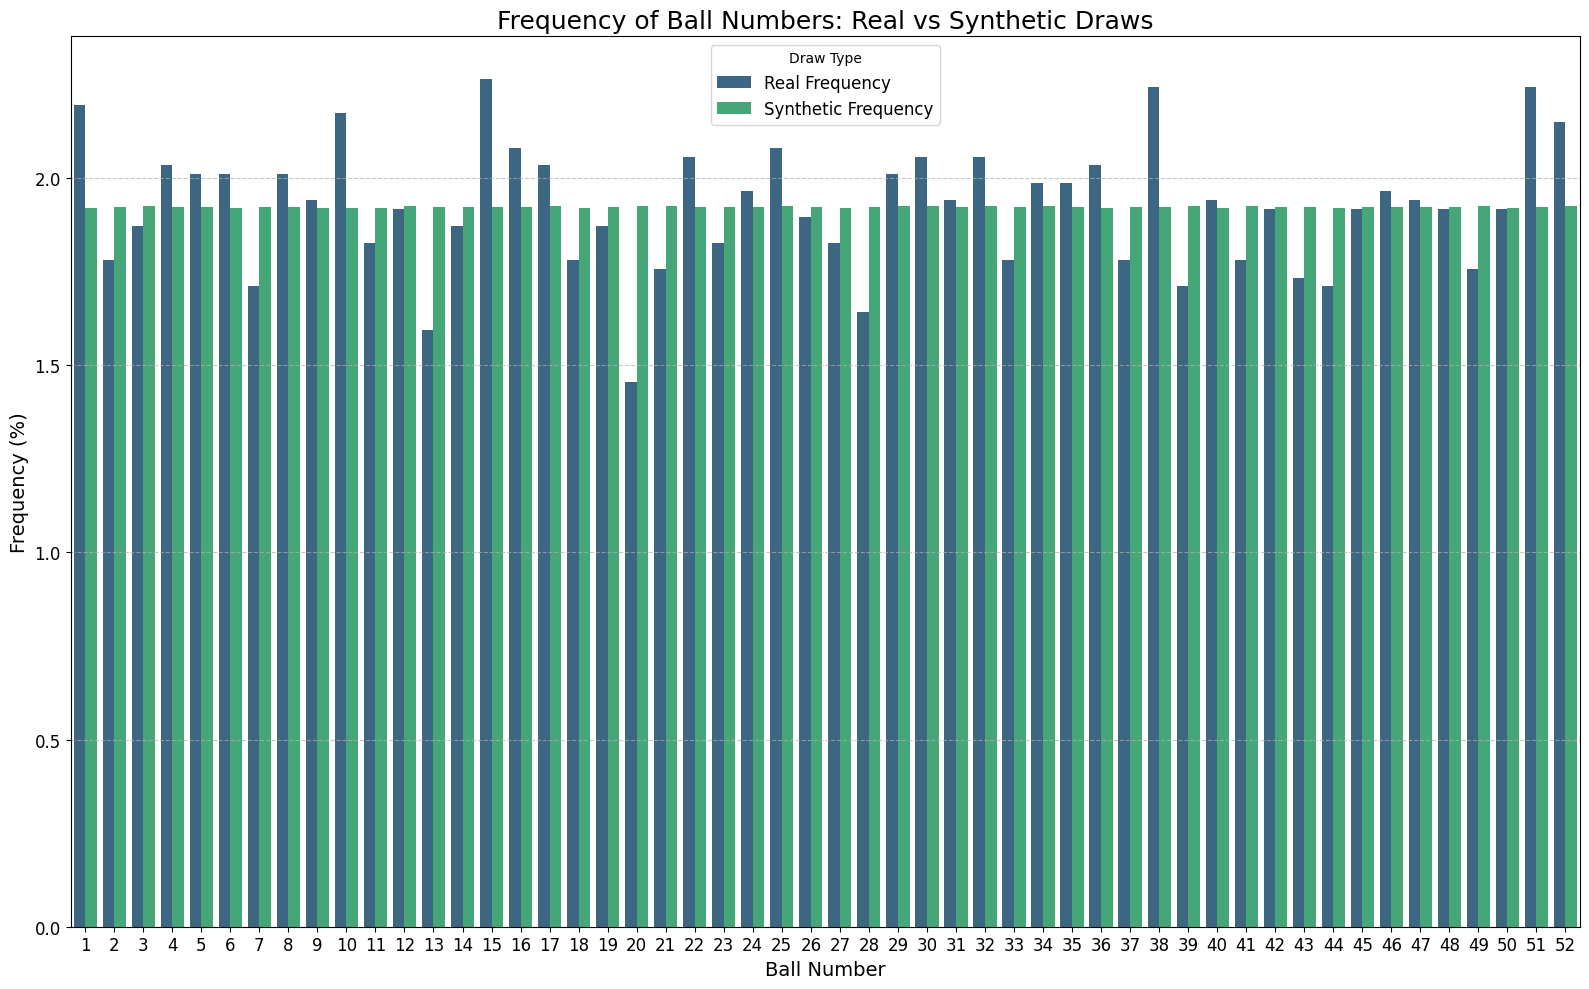

In [16]:
# Plot the data
plt.figure(figsize=(16, 10))
sns.barplot(data=combined_counts, x='Ball Number', y='Frequency', hue='Category', dodge=True, palette="viridis")
plt.title("Frequency of Ball Numbers: Real vs Synthetic Draws", fontsize=18)
plt.xlabel("Ball Number", fontsize=14)
plt.ylabel("Frequency (%)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Draw Type', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

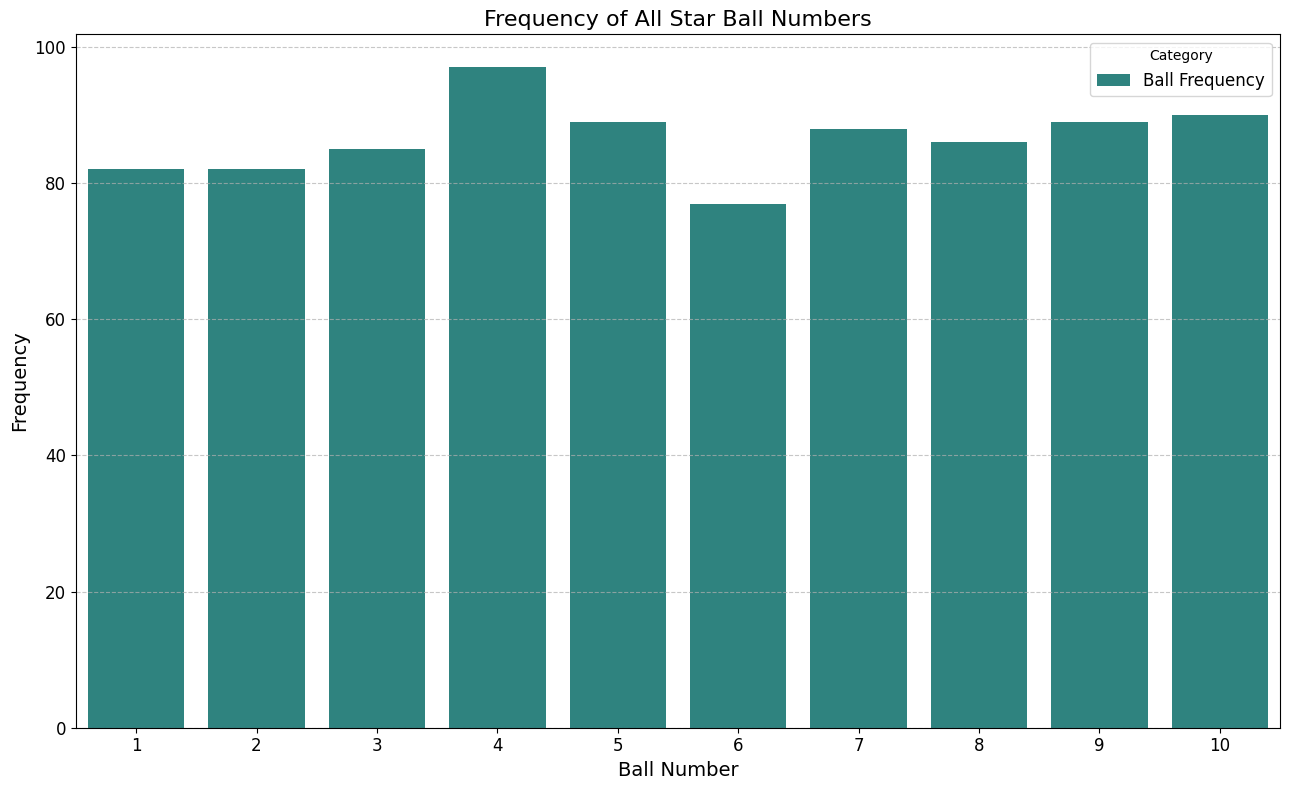

In [17]:
counts = df2['All Star Ball'].values
ball_counts = pd.Series(counts).value_counts().reset_index()
ball_counts.columns = ['Ball Number', 'Frequency']

# Create a new column for hue to categorize as "Ball Frequency"
ball_counts['Category'] = 'Ball Frequency'

# Create the plot
plt.figure(figsize=(13, 8))
sns.barplot(data=ball_counts, x='Ball Number', y='Frequency', hue='Category', dodge=False, palette="viridis")
plt.title("Frequency of All Star Ball Numbers", fontsize=16)
plt.xlabel("Ball Number", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Category', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [18]:
def count_even_odd(row):
    even_count = sum(num % 2 == 0 for num in row)
    odd_count = len(row) - even_count
    return pd.Series({"Even": even_count, "Odd": odd_count})


df_counts = df2[ball_list].apply(count_even_odd, axis=1)
df2['Even'] = df_counts['Even']
df2['Odd'] = df_counts['Odd']
df2.head()

,Ball 1,Ball 2,Ball 3,Ball 4,Ball 5,All Star Ball,Multiplier,Even,Odd
"Wed, Dec 11, 2024",4,14,30,45,50,4,2x,4,1
"Mon, Dec 9, 2024",15,24,29,38,51,3,3x,2,3
"Sat, Dec 7, 2024",7,14,31,44,46,8,5x,3,2
"Wed, Dec 4, 2024",10,13,32,42,44,9,4x,4,1
"Mon, Dec 2, 2024",1,20,37,39,47,4,2x,1,4


In [19]:
# Create a 'Distribution' column combining Odd and Even counts
df2["Distribution"] = df2.apply(lambda x: f"{int(x['Odd'])} Odd, {int(x['Even'])} Even", axis=1)
distribution_counts = df2["Distribution"].value_counts(normalize=True) * 100

# Convert to DataFrame for plotting
distribution_df = distribution_counts.reset_index()
distribution_df.columns = ["Distribution", "Percentage"]
distribution_df

,Distribution,Percentage
0,"2 Odd, 3 Even",35.260116
1,"3 Odd, 2 Even",31.329480
2,"1 Odd, 4 Even",15.144509
3,"4 Odd, 1 Even",14.104046
4,"5 Odd, 0 Even",2.196532
5,"0 Odd, 5 Even",1.965318


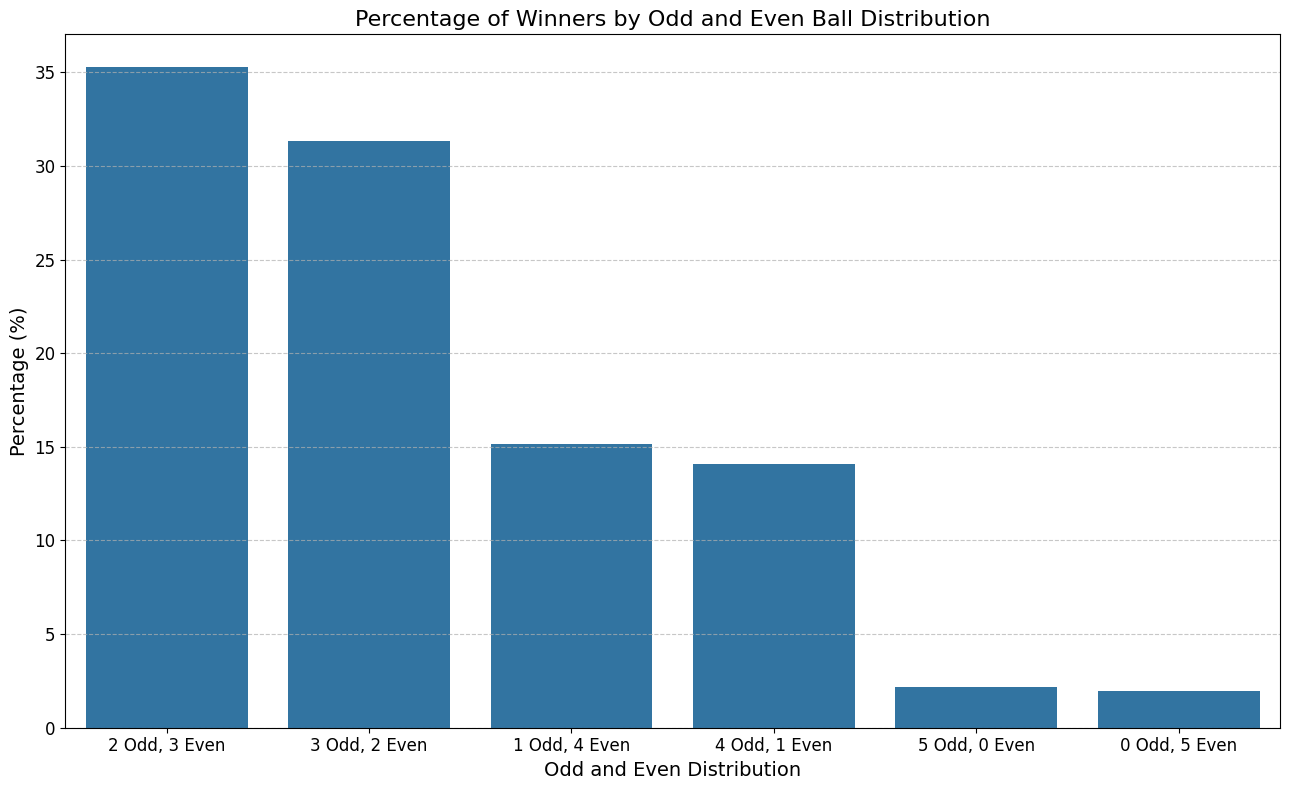

In [20]:
# Plot the results
plt.figure(figsize=(13, 8))
sns.barplot(data=distribution_df, x="Distribution", y="Percentage")
plt.title("Percentage of Winners by Odd and Even Ball Distribution", fontsize=16)
plt.xlabel("Odd and Even Distribution", fontsize=14)
plt.ylabel("Percentage (%)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [21]:
# Compute all possible combinations of 5 balls, WIP
all_balls = range(1, 52 + 1)
combinations = itertools.combinations(all_balls, 5)
all_possible_sums = set([sum(comb) for comb in combinations])

In [22]:
def sum_balls(list):
    return sum(list)

df2['Sum'] = df2[ball_list].apply(sum_balls, axis=1)
df2.head()

,Ball 1,Ball 2,Ball 3,Ball 4,Ball 5,All Star Ball,Multiplier,Even,Odd,Distribution,Sum
"Wed, Dec 11, 2024",4,14,30,45,50,4,2x,4,1,"1 Odd, 4 Even",143
"Mon, Dec 9, 2024",15,24,29,38,51,3,3x,2,3,"3 Odd, 2 Even",157
"Sat, Dec 7, 2024",7,14,31,44,46,8,5x,3,2,"2 Odd, 3 Even",142
"Wed, Dec 4, 2024",10,13,32,42,44,9,4x,4,1,"1 Odd, 4 Even",141
"Mon, Dec 2, 2024",1,20,37,39,47,4,2x,1,4,"4 Odd, 1 Even",144


In [23]:
frequency_dict = {s: 0 for s in all_possible_sums}

# Count occurrences of each sum in the DataFrame
for sum_value in df2['Sum']:
    if sum_value in frequency_dict:
        frequency_dict[sum_value] += 1

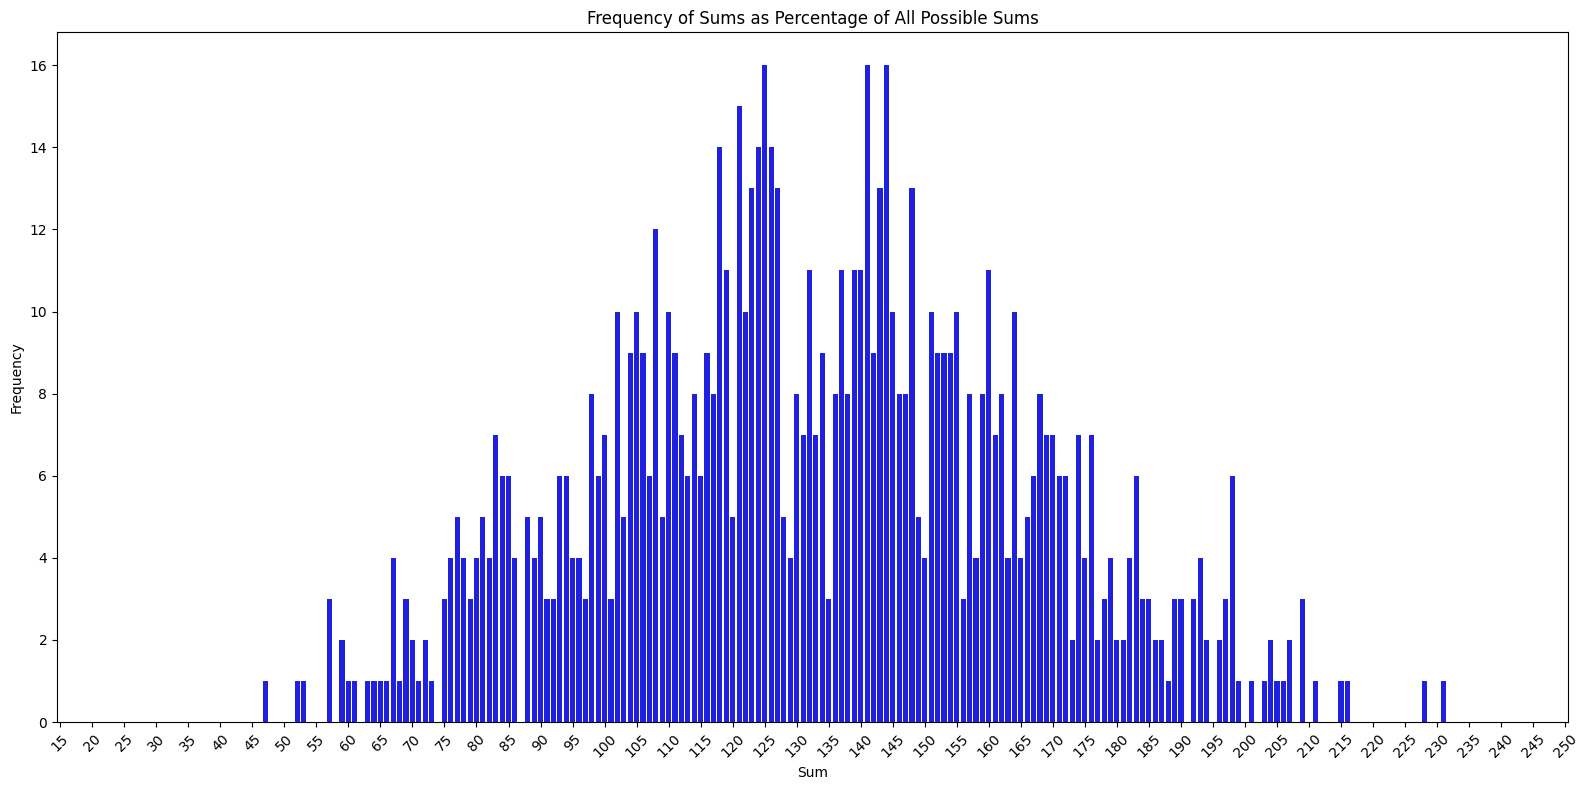

In [24]:
plot_data = pd.DataFrame({
    'Sum': list(frequency_dict.keys()),
    'Frequency': list(frequency_dict.values())
})
plt.figure(figsize=(16, 8))
sns.barplot(data=plot_data.sort_values('Sum'), x='Sum', y='Frequency', color='blue')
plt.title('Frequency of Sums as Percentage of All Possible Sums')
plt.xlabel('Sum')
plt.ylabel('Frequency')
plt.xticks(ticks=range(0, len(plot_data['Sum']), max(1, len(plot_data['Sum']) // 40)), rotation=45)
plt.tight_layout()
plt.show()